<a href="https://colab.research.google.com/github/NicolasManuelKoch/cap-comp215/blob/main/Project_2_Nicolas_Manuel_Koch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author:** Nicolas Manuel Koch

**Date:** 2023/04/13

**Purpose:** To add realism to the ForestFire class that we developed in the Lab and find out how the different Factors that are added, changes our model of the spread of a fire.

In [63]:
%matplotlib inline

import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from scipy.signal import correlate2d

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

In [64]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap='Blues',
    interpolation='none',
    origin='upper',
)


def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [65]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass



In [66]:
import random
class ForestFire1:
    """ 2D Cellular Automaton that simulates a fire-dominated landscape """

    # Define names for the 3 possible cell states
    EMPTY = 0
    OCCUPIED = 1
    FIRE = 5

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(1, 0.5, 0), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
    cmap[EMPTY] = (1, 0.5, 0)  # brown 1, 0.5, 0
    cmap[OCCUPIED] = (0, 1, 0)  # green
    cmap[FIRE] = (1, 0, 0)  # red
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    # TODO: define a sensible correlation kernel
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])


    def __init__(self, n=3, p=0.01, f=0.001, q=0.5):
        """Initializes the model.

        n: number of rows
        p: probability an empty cells becomes "forested" (occupied)
        f: probability of spontaneous fire (e.g., 1/fire ignition interval)
        q: initial forest density (probability cell is "forested" in initial state)
        """
        self.probability_random_forested = p
        self.probability_random_fire = f
        # initialize landscape with approx. q proportion of cells OCCUPIED
        self.array = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])



    def step(self):
        """Executes one time step, applying the CA rules to regenerate and burn forest."""

        self.FIRE = 10 #set the value of the cells that are on fire to 10 (in order to be able to distinguish between burning cells and 8 neighbours with a tree (values 10 vs 8 resp. 9))
        burnt_trees = (self.array==self.FIRE) # identifies trees that caught fire in the previous timestep and assigns them to brunt_trees

        #empty cell becomrs occupied with probability p
        empty_cells = np.where(self.array == self.EMPTY)
        randomly_occupied = np.random.random(empty_cells[0].shape)
        self.array[empty_cells[0][randomly_occupied < self.probability_random_forested], 
        empty_cells[1][randomly_occupied < self.probability_random_forested]] = self.OCCUPIED

       
        #cell with a tree burns if any of its neighbors is on fire
        c = correlate2d(self.array, self.kernel, mode='same', boundary='wrap')
        catching_fire = (self.array==self.OCCUPIED) & (c>=self.FIRE) 
        self.array[catching_fire] = self.FIRE


        #set a random cell (probability_random_fire) on fire, even without any neighbours on fire
        forested_cells = np.where(self.array == self.OCCUPIED)
        for i in range(forested_cells[0].shape[0]):
          if random.random() < self.probability_random_fire:
            self.array[forested_cells[0][i], forested_cells[1][i]] = self.FIRE

        #cell that was on fire in previous timestep is set to empty (burnt)
        self.array[burnt_trees] = self.EMPTY

    def num_occupied(self):
        """ return the number of cells occupied by forest """
        return np.sum(self.array == self.OCCUPIED)  # TODO: count the number of forested cells.


    def pct_occupied(self):
        """ return the proportion of cells occupied by forest """
        return self.num_occupied() / self.array.size


    def draw(self, axes=None, step=''):
        """Draws the CA cells using the forest colour map so values are coloured intuitively."""
        axes = axes or plt.axes
        title = f'Time:{step} Occupied: {round(self.pct_occupied() * 100, 2)}%'
        plot_2D_array(self.array, axes=axes, title=title,
                      cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))




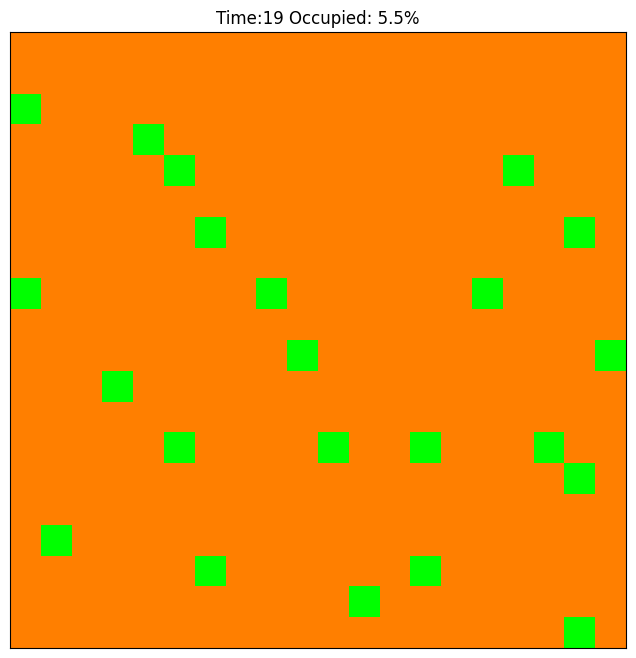

In [67]:

# initialize object and grid with all parameteres nr of rows (n), probability_random_forested (p), probability_random_fire (f) and initial forest density (q)
fire = ForestFire1(20, 0.01, 0.001, 0.5) 

# create Animation2D object & set number of frames/steps per frame
animation = Animation2D(fire, frames=20, steps_per_frame=1)

animation.animate(interval=0.3)




In [68]:
import timeit

#define fire model 1
fire1 = ForestFire1(100, 0.01, 0.001, 1) 

fire11 = ForestFire1(100, 0.01, 0.001, 0.1) 

fire111 = ForestFire1(100, p=0.01, f=0.01, q=0.5) 

fire1111 = ForestFire1(100, p=0.1, f=0.001, q=0.5) 


In [69]:
import random
class ForestFire2:
    """ 2D Cellular Automaton that simulates a fire-dominated landscape """

    # Define names for the 3 possible cell states
    EMPTY = 0
    OCCUPIED = 1
    FIRE = 5

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(1, 0.5, 0), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
    cmap[EMPTY] = (1, 0.5, 0)  # brown 1, 0.5, 0
    cmap[OCCUPIED] = (0, 1, 0)  # green
    cmap[FIRE] = (1, 0, 0)  # red
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    # TODO: define a sensible correlation kernel
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])


    def __init__(self, n=3, p=0.01, f=0.001, q=0.5):
        """Initializes the model.

        n: number of rows
        p: probability an empty cells becomes "forested" (occupied)
        f: probability of spontaneous fire (e.g., 1/fire ignition interval)
        q: initial forest density (probability cell is "forested" in initial state)
        """
        self.probability_random_forested = p
        self.probability_random_fire = f
        # initialize landscape with approx. q proportion of cells OCCUPIED
        self.array = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])
        self.tree_age = np.zeros_like(self.array)  # initialize tree age array


    def step(self):
        """Executes one time step, applying the CA rules to regenerate and burn forest."""
        # Update tree age array
        self.tree_age[self.array == self.OCCUPIED] += 1

        self.FIRE = 10 #set the value of the cells that are on fire to 10 (in order to be able to distinguish between burning cells and 8 neighbours with a tree (values 10 vs 8 resp. 9))
        burnt_trees = (self.array==self.FIRE) # identifies trees that caught fire in the previous timestep and assigns them to brunt_trees

        #empty cell becomrs occupied with probability p
        empty_cells = np.where(self.array == self.EMPTY)
        randomly_occupied = np.random.random(empty_cells[0].shape)
        self.array[empty_cells[0][randomly_occupied < self.probability_random_forested], 
        empty_cells[1][randomly_occupied < self.probability_random_forested]] = self.OCCUPIED

       
        #cell with a tree burns if any of its neighbors is on fire
        c = correlate2d(self.array, self.kernel, mode='same', boundary='wrap')
        catching_fire = (self.array==self.OCCUPIED) & (c>=self.FIRE) 
        self.array[catching_fire] = self.FIRE

        #AGE FACTOR: Find the indices where the fire has caught fire in this timesteps (by a neighbour, not randomly) and use them to update the array of the forest, by setting a tree that would have caught fire as occupied (not catching fire anymore). The older the tree, the higher the chance that it continues to catch fire.
        indices = np.where(catching_fire)
        for i in range(len(indices[0])):
            x = (indices[0][i], indices[1][i])  # Get the indices along each dimension
            if self.tree_age[x] > 0 and random.randint(1, self.tree_age[x]) == 1:
                self.array[x] = self.OCCUPIED
            else:
                self.tree_age[x] = 0

        #set a random cell (probability_random_fire) on fire, even without any neighbours on fire
        forested_cells = np.where(self.array == self.OCCUPIED)
        for i in range(forested_cells[0].shape[0]):
          if random.random() < self.probability_random_fire:
            self.array[forested_cells[0][i], forested_cells[1][i]] = self.FIRE

        #cell that was on fire in previous timestep is set to empty (burnt)
        self.array[burnt_trees] = self.EMPTY

    def num_occupied(self):
        """ return the number of cells occupied by forest """
        return np.sum(self.array == self.OCCUPIED)  # TODO: count the number of forested cells.


    def pct_occupied(self):
        """ return the proportion of cells occupied by forest """
        return self.num_occupied() / self.array.size


    def draw(self, axes=None, step=''):
        """Draws the CA cells using the forest colour map so values are coloured intuitively."""
        axes = axes or plt.axes
        title = f'Time:{step} Occupied: {round(self.pct_occupied() * 100, 2)}%'
        plot_2D_array(self.array, axes=axes, title=title,
                      cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))
        




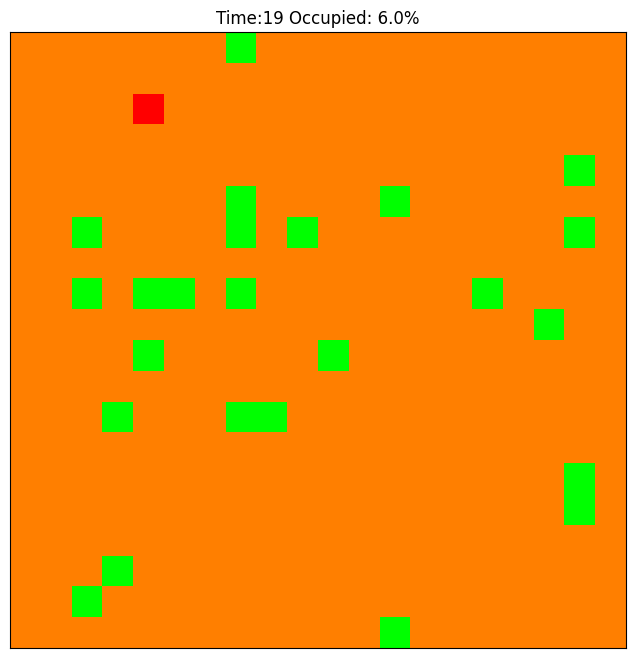

In [70]:
# initialize object and grid with all parameteres nr of rows (n), probability_random_forested (p), probability_random_fire (f) and initial forest density (q)
fire = ForestFire2(20, 0.01, 0.001, 0.5) 

# create Animation2D object & set number of frames/steps per frame
animation = Animation2D(fire, frames=20, steps_per_frame=1)

animation.animate(interval=0.3)



In [71]:
#define fire model 2
fire2 = ForestFire2(100, 0.01, 0.001, 1) 

fire22 = ForestFire2(100, 0.01, 0.001, 0.1) 

fire222 = ForestFire2(100, p=0.01, f=0.01, q=0.5) 

fire2222 = ForestFire2(100, p=0.1, f=0.001, q=0.5) 


In [72]:
from re import X
import random
class ForestFire3:
    """ 2D Cellular Automaton that simulates a fire-dominated landscape """

    # Define names for the 3 possible cell states
    EMPTY = 0
    OCCUPIED = 1
    FIRE = 5

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(1, 0.5, 0), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
    cmap[EMPTY] = (1, 0.5, 0)  # brown 1, 0.5, 0
    cmap[OCCUPIED] = (0, 1, 0)  # green
    cmap[FIRE] = (1, 0, 0)  # red
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    # TODO: define a sensible correlation kernel
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])


    def __init__(self, n=3, p=0.01, f=0.001, q=0.5):
        """Initializes the model.

        n: number of rows
        p: probability an empty cells becomes "forested" (occupied)
        f: probability of spontaneous fire (e.g., 1/fire ignition interval)
        q: initial forest density (probability cell is "forested" in initial state)
        """
        self.probability_random_forested = p
        self.probability_random_fire = f
        # initialize landscape with approx. q proportion of cells OCCUPIED
        self.array = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])
        self.tree_age = np.zeros_like(self.array)  # initialize tree age array
        self.temperature = np.zeros_like(self.array)  # initialize tree age array


    def step(self):
        """Executes one time step, applying the CA rules to regenerate and burn forest."""
        # Update tree age array
        self.tree_age[self.array == self.OCCUPIED] += 1

        # Temperature
        if np.any(self.temperature == 30) or np.any(self.temperature == 0):
          self.temperature = random.randint(1, 29) 

        self.temperature += random.randint(-1, 1)

        self.FIRE = 10 #set the value of the cells that are on fire to 10 (in order to be able to distinguish between burning cells and 8 neighbours with a tree (values 10 vs 8 resp. 9))
        burnt_trees = (self.array==self.FIRE) # identifies trees that caught fire in the previous timestep and assigns them to brunt_trees

        #empty cell becomrs occupied with probability p
        empty_cells = np.where(self.array == self.EMPTY)
        randomly_occupied = np.random.random(empty_cells[0].shape)
        self.array[empty_cells[0][randomly_occupied < self.probability_random_forested], 
        empty_cells[1][randomly_occupied < self.probability_random_forested]] = self.OCCUPIED

       
        #cell with a tree burns if any of its neighbors is on fire
        c = correlate2d(self.array, self.kernel, mode='same', boundary='wrap')
        catching_fire = (self.array==self.OCCUPIED) & (c>=self.FIRE) 
        self.array[catching_fire] = self.FIRE

        #AGE FACTOR: Find the indices where the fire has caught fire in this timesteps (by a neighbour, not randomly) and use them to update the array of the forest, by setting a tree that would have caught fire as occupied (not catching fire anymore). The older the tree, the higher the chance that it continues to catch fire.
        indices = np.where(catching_fire)
        for i in range(len(indices[0])):
            x = (indices[0][i], indices[1][i])  # Get the indices along each dimension
            if self.tree_age[x] > 0 and random.randint(1, self.tree_age[x]) == 1:
                self.array[x] = self.OCCUPIED
            else:
                self.tree_age[x] = 0

        #TEMPERATURE FACTOR: Identify where in the array trees caught fire in this timestep, then the higher the temperature of the forest, the higher the chance that these trees continue on burning.
        neighbour_fire = np.where(catching_fire)
        for i in range(neighbour_fire[0].shape[0]):
          if random.randint(0, self.temperature + 3) in [0, 1, 2]:
            self.array[neighbour_fire[0][i], neighbour_fire[1][i]] = self.OCCUPIED
        

        #set a random cell (probability_random_fire) on fire, even without any neighbours on fire
        forested_cells = np.where(self.array == self.OCCUPIED)
        for i in range(forested_cells[0].shape[0]):
          if random.random() < self.probability_random_fire:
            self.array[forested_cells[0][i], forested_cells[1][i]] = self.FIRE

        #cell that was on fire in previous timestep is set to empty (burnt)
        self.array[burnt_trees] = self.EMPTY

    def num_occupied(self):
        """ return the number of cells occupied by forest """
        return np.sum(self.array == self.OCCUPIED)  # TODO: count the number of forested cells.


    def pct_occupied(self):
        """ return the proportion of cells occupied by forest """
        return self.num_occupied() / self.array.size


    def draw(self, axes=None, step=''):
        """Draws the CA cells using the forest colour map so values are coloured intuitively."""
        axes = axes or plt.axes
        title = f'Time:{step} Occupied: {round(self.pct_occupied() * 100, 2)}%'
        plot_2D_array(self.array, axes=axes, title=title,
                      cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))
        





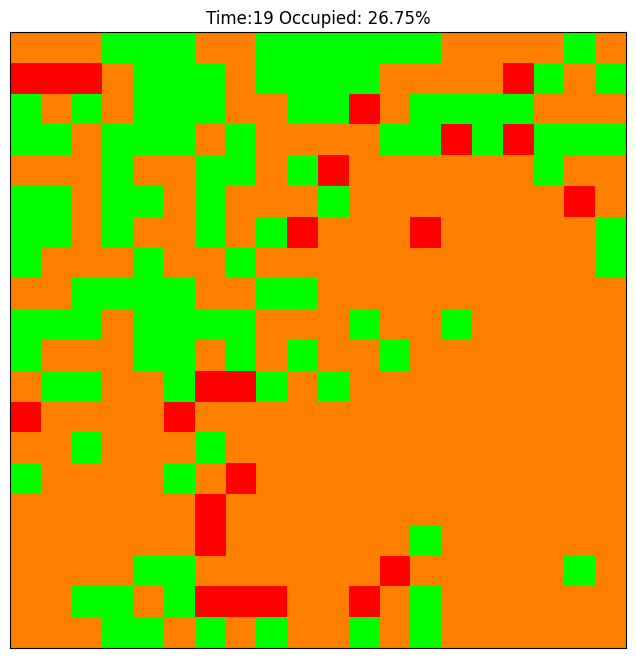

In [73]:
# initialize object and grid with all parameteres nr of rows (n), probability_random_forested (p), probability_random_fire (f) and initial forest density (q)
fire = ForestFire3(20, 0.01, 0.001, 0.5) 

# create Animation2D object & set number of frames/steps per frame
animation = Animation2D(fire, frames=20, steps_per_frame=1)

animation.animate(interval=0.3)



In [74]:
#define fire model 3
fire3 = ForestFire3(100, 0.01, 0.001, 1) 

fire33 = ForestFire3(100, 0.01, 0.001, 0.1) 

fire333 = ForestFire3(100, p=0.01, f=0.01, q=0.5) 

fire3333 = ForestFire3(100, p=0.1, f=0.001, q=0.5) 


In [75]:
from re import X
import random
class ForestFire4:
    """ 2D Cellular Automaton that simulates a fire-dominated landscape """

    # Define names for the 3 possible cell states
    EMPTY = 0
    OCCUPIED = 1
    FIRE = 5

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(1, 0.5, 0), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
    cmap[EMPTY] = (1, 0.5, 0)  # brown 1, 0.5, 0
    cmap[OCCUPIED] = (0, 1, 0)  # green
    cmap[FIRE] = (1, 0, 0)  # red
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    # TODO: define a sensible correlation kernel
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])


    def __init__(self, n=3, p=0.01, f=0.001, q=0.5):
        """Initializes the model.

        n: number of rows
        p: probability an empty cells becomes "forested" (occupied)
        f: probability of spontaneous fire (e.g., 1/fire ignition interval)
        q: initial forest density (probability cell is "forested" in initial state)
        """
        self.probability_random_forested = p
        self.probability_random_fire = f
        # initialize landscape with approx. q proportion of cells OCCUPIED
        self.array = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])
        self.tree_age = np.zeros_like(self.array)  # initialize tree age array
        self.temperature = np.zeros_like(self.array)  # initialize forest temp array
        self.moisture = np.zeros_like(self.array) # initialize forest moisture array


    def step(self):
        """Executes one time step, applying the CA rules to regenerate and burn forest."""
        #Tree age
        self.tree_age[self.array == self.OCCUPIED] += 1

        #Temperature
        if np.any(self.temperature == 30) or np.any(self.temperature == 0):
          self.temperature = random.randint(1, 29) 
        self.temperature += random.randint(-1, 1)
        
        #Moisture: Set up mooisture of the forest and always make sure to keep relative humidity between 20 - 60%, without extreme differences between timesteps
        if np.any(self.moisture[self.array] == 0):
          self.moisture[self.array] = np.where(self.moisture[self.array] == 0, random.randint(20, 60), self.moisture[self.array])
        self.moisture[self.array] += random.randint(-3, 3)
        if np.any(self.moisture[self.array] > 60):
          self.moisture[self.array] += random.randint(-6, -3)
        if np.any(self.moisture[self.array] < 20):
          self.moisture[self.array] += random.randint(3, 6)
  

        self.FIRE = 10 #set the value of the cells that are on fire to 10 (in order to be able to distinguish between burning cells and 8 neighbours with a tree (values 10 vs 8 resp. 9))
        burnt_trees = (self.array==self.FIRE) # identifies trees that caught fire in the previous timestep and assigns them to brunt_trees

        #empty cell becomrs occupied with probability p
        empty_cells = np.where(self.array == self.EMPTY)
        randomly_occupied = np.random.random(empty_cells[0].shape)
        self.array[empty_cells[0][randomly_occupied < self.probability_random_forested], 
        empty_cells[1][randomly_occupied < self.probability_random_forested]] = self.OCCUPIED

       
        #cell with a tree burns if any of its neighbors is on fire
        c = correlate2d(self.array, self.kernel, mode='same', boundary='wrap')
        catching_fire = (self.array==self.OCCUPIED) & (c>=self.FIRE) 
        self.array[catching_fire] = self.FIRE

        #AGE FACTOR: Find the indices where the fire has caught fire in this timesteps (by a neighbour, not randomly) and use them to update the array of the forest, by setting a tree that would have caught fire as occupied (not catching fire anymore). The older the tree, the higher the chance that it continues to catch fire.
        indices = np.where(catching_fire)
        for i in range(len(indices[0])):
            x = (indices[0][i], indices[1][i])  # Get the indices along each dimension
            if self.tree_age[x] > 0 and random.randint(1, self.tree_age[x]) == 1:
                self.array[x] = self.OCCUPIED
            else:
                self.tree_age[x] = 0

        #TEMPERATURE FACTOR: Identify where in the array trees caught fire in this timestep, then the higher the temperature of the forest, the higher the chance that these trees continue on burning.
        neighbour_fire = np.where(catching_fire)
        for i in range(neighbour_fire[0].shape[0]):
          if random.randint(0, self.temperature + 3) in [0, 1, 2]:
            self.array[neighbour_fire[0][i], neighbour_fire[1][i]] = self.OCCUPIED
        
        #MOISTURE FACTOR: Identify where in the array trees caught fire in this timestep, then the lower the moisture, the higher the chance that the tree does indeed burn.
        moisture = np.where(catching_fire)
        for i in range(moisture[0].shape[0]):
          if not random.randint(0, self.moisture[moisture[0][i], moisture[1][i]] + 3) in [0, 1, 2]:
              self.array[moisture[0][i], moisture[1][i]] = self.OCCUPIED

        #set a random cell (probability_random_fire) on fire, even without any neighbours on fire
        forested_cells = np.where(self.array == self.OCCUPIED)
        for i in range(forested_cells[0].shape[0]):
          if random.random() < self.probability_random_fire:
            self.array[forested_cells[0][i], forested_cells[1][i]] = self.FIRE

        #cell that was on fire in previous timestep is set to empty (burnt)
        self.array[burnt_trees] = self.EMPTY

    def num_occupied(self):
        """ return the number of cells occupied by forest """
        return np.sum(self.array == self.OCCUPIED)  # TODO: count the number of forested cells.


    def pct_occupied(self):
        """ return the proportion of cells occupied by forest """
        return self.num_occupied() / self.array.size


    def draw(self, axes=None, step=''):
        """Draws the CA cells using the forest colour map so values are coloured intuitively."""
        axes = axes or plt.axes
        title = f'Time:{step} Occupied: {round(self.pct_occupied() * 100, 2)}%'
        plot_2D_array(self.array, axes=axes, title=title,
                      cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))
        



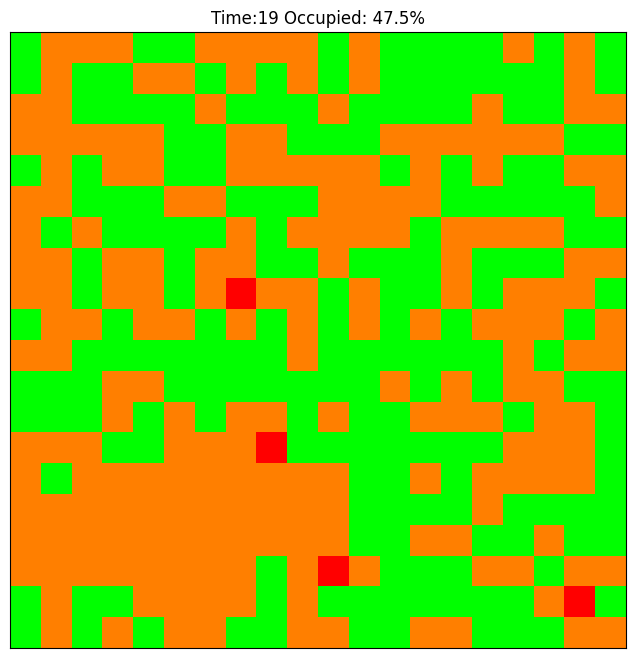

In [76]:
# initialize object and grid with all parameteres nr of rows (n), probability_random_forested (p), probability_random_fire (f) and initial forest density (q)
fire = ForestFire4(20, 0.01, 0.001, 0.5) 

# create Animation2D object & set number of frames/steps per frame
animation = Animation2D(fire, frames=20, steps_per_frame=1)

animation.animate(interval=0.3)



In [77]:
#define fire model 4
fire4 = ForestFire4(100, 0.01, 0.001, 1) 

fire44 = ForestFire4(100, 0.01, 0.001, 0.1) 

fire444 = ForestFire4(100, p=0.01, f=0.01, q=0.5) 

fire4444 = ForestFire4(100, p=0.1, f=0.001, q=0.5) 



In [78]:
from re import X
import random
import timeit

class ForestFire5:
    """ 2D Cellular Automaton that simulates a fire-dominated landscape """

    # Define names for the 3 possible cell states
    EMPTY = 0
    OCCUPIED = 1
    FIRE = 5

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(1, 0.5, 0), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
    cmap[EMPTY] = (1, 0.5, 0)  # brown 1, 0.5, 0
    cmap[OCCUPIED] = (0, 1, 0)  # green
    cmap[FIRE] = (1, 0, 0)  # red
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    # TODO: define a sensible correlation kernel
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])


    def __init__(self, n=3, p=0.01, f=0.001, q=0.5):
        """Initializes the model.

        n: number of rows
        p: probability an empty cells becomes "forested" (occupied)
        f: probability of spontaneous fire (e.g., 1/fire ignition interval)
        q: initial forest density (probability cell is "forested" in initial state)
        """
        self.probability_random_forested = p
        self.probability_random_fire = f
        # initialize landscape with approx. q proportion of cells OCCUPIED
        self.array = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])
        self.tree_age = np.zeros_like(self.array)  # initialize tree age array
        self.temperature = np.zeros_like(self.array)  # initialize temperature array
        self.moisture = np.zeros_like(self.array) # initialize moisture array
        self.fuel_loads = np.zeros_like(self.array)# initialize fuel_loads array
        self.num_patches = 0 # initialize num_patches array
        self.patch_size = 0 # initialize patch_size array


    def step(self):
        """Executes one time step, applying the CA rules to regenerate and burn forest."""
        #Age: where the cells are occupied in the sel.array, add 1 to the age of the tree
        self.tree_age[self.array == self.OCCUPIED] += 1

        #Temperature: Keep the temperature between 0 and 30
        if np.any(self.temperature == 30) or np.any(self.temperature == 0):
          self.temperature = random.randint(1, 29) 
        self.temperature += random.randint(-1, 1)
        
        #Moisture: Set up mooisture of the forest and always make sure to keep relative humidity between 20 - 60%, without extreme differences between timesteps
        if np.any(self.moisture[self.array] == 0):
          self.moisture[self.array] = np.where(self.moisture[self.array] == 0, random.randint(20, 60), self.moisture[self.array])
        self.moisture[self.array] += random.randint(-3, 3)
        if np.any(self.moisture[self.array] > 60):
          self.moisture[self.array] += random.randint(-6, -3)
        if np.any(self.moisture[self.array] < 20):
          self.moisture[self.array] += random.randint(3, 6)

        #Fuel loads: Set up fuel loads by creating areas in the array, each assigned a different value for ffuel load between 2 and 20. Keep fuel loads in all the areas that there is higher fuel loads above 2.
        if np.all(self.fuel_loads == 0):
          self.num_patches = random.randint(1, 16)
        self.patch_size = (random.randint(0, len(self.array[0])//4), random.randint(0, len(self.array[0])//4))
        for i in range(self.num_patches):
          # Generate random starting coordinates for the patch
          start_x = np.random.randint(0, (self.array.shape[0] - self.patch_size[0]) + 1)
          start_y = np.random.randint(0, (self.array.shape[1] - self.patch_size[1]) + 1)
          # Set the values in the patch to between 2 and 20
          if np.all(self.fuel_loads[start_x:start_x + self.patch_size[0], start_y:start_y + self.patch_size[1]] == 0):
            self.fuel_loads[start_x:start_x + self.patch_size[0], start_y:start_y + self.patch_size[1]] = np.random.randint(2, 20)
        # keep values above 0
        if self.num_patches > 2:
          self.num_patches += random.randint(-2, 2)
        else:
          self.num_patches += random.randint(2, 4)

        self.FIRE = 10 #set the value of the cells that are on fire to 10 (in order to be able to distinguish between burning cells and 8 neighbours with a tree (values 10 vs 8 resp. 9))
        burnt_trees = (self.array==self.FIRE) # identifies trees that caught fire in the previous timestep and assigns them to brunt_trees

        #empty cell becomrs occupied with probability p
        empty_cells = np.where(self.array == self.EMPTY)
        randomly_occupied = np.random.random(empty_cells[0].shape)
        self.array[empty_cells[0][randomly_occupied < self.probability_random_forested], 
        empty_cells[1][randomly_occupied < self.probability_random_forested]] = self.OCCUPIED

       
        #cell with a tree burns if any of its neighbors is on fire
        c = correlate2d(self.array, self.kernel, mode='same', boundary='wrap')
        catching_fire = (self.array==self.OCCUPIED) & (c>=self.FIRE) 
        self.array[catching_fire] = self.FIRE

        #AGE FACTOR: Find the indices where the fire has caught fire in this timesteps (by a neighbour, not randomly) and use them to update the array of the forest, by setting a tree that would have caught fire as occupied (not catching fire anymore). The older the tree, the higher the chance that it continues to catch fire.
        indices = np.where(catching_fire)
        for i in range(len(indices[0])):
            x = (indices[0][i], indices[1][i])  # Get the indices along each dimension
            if self.tree_age[x] > 0 and random.randint(1, self.tree_age[x]) == 1:
                self.array[x] = self.OCCUPIED
            #if the tree really burns, set its age to 0.
            else:
                self.tree_age[x] = 0

        #TEMPERATURE FACTOR: Identify where in the array trees caught fire in this timestep, then the higher the temperature of the forest, the higher the chance that these trees continue on burning.
        neighbour_fire = np.where(catching_fire)
        for i in range(neighbour_fire[0].shape[0]):
          if random.randint(0, self.temperature + 3) in [0, 1, 2]:
            self.array[neighbour_fire[0][i], neighbour_fire[1][i]] = self.OCCUPIED

        #MOISTURE FACTOR: Identify where in the array trees caught fire in this timestep, then the lower the moisture, the higher the chance that the tree does indeed burn.
        moisture = np.where(catching_fire)
        for i in range(moisture[0].shape[0]):
          if not random.randint(0, self.moisture[moisture[0][i], moisture[1][i]] + 3) in [0, 1, 2]:
              self.array[moisture[0][i], moisture[1][i]] = self.OCCUPIED

        #FUEL LOADS FACTOR: Identify where in the array trees caught fire in this timestep, then the higher the fuel loads, the higher the chance the tree indeed burns in this timestep.
        loads = np.where(catching_fire)
        for i in range(loads[0].shape[0]):
          if random.randint(0, self.fuel_loads[loads[0][i], loads[1][i]]) in [0, 1] and self.fuel_loads[loads[0][i], loads[1][i]] != 0:
            self.array[neighbour_fire[0][i], neighbour_fire[1][i]] = self.OCCUPIED


        #set a random cell (probability_random_fire) on fire, even without any neighbours on fire
        forested_cells = np.where(self.array == self.OCCUPIED)
        for i in range(forested_cells[0].shape[0]):
          if random.random() < self.probability_random_fire:
            self.array[forested_cells[0][i], forested_cells[1][i]] = self.FIRE

        #cell that was on fire in previous timestep is set to empty (burnt)
        self.array[burnt_trees] = self.EMPTY


    def num_occupied(self):
        """ return the number of cells occupied by forest """
        return np.sum(self.array == self.OCCUPIED) 


    def pct_occupied(self):
        """ return the proportion of cells occupied by forest """
        return self.num_occupied() / self.array.size


    def draw(self, axes=None, step=''):
        """Draws the CA cells using the forest colour map so values are coloured intuitively."""
        axes = axes or plt.axes
        title = f'Time:{step} Occupied: {round(self.pct_occupied() * 100, 2)}%'
        plot_2D_array(self.array, axes=axes, title=title,
                      cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))
        



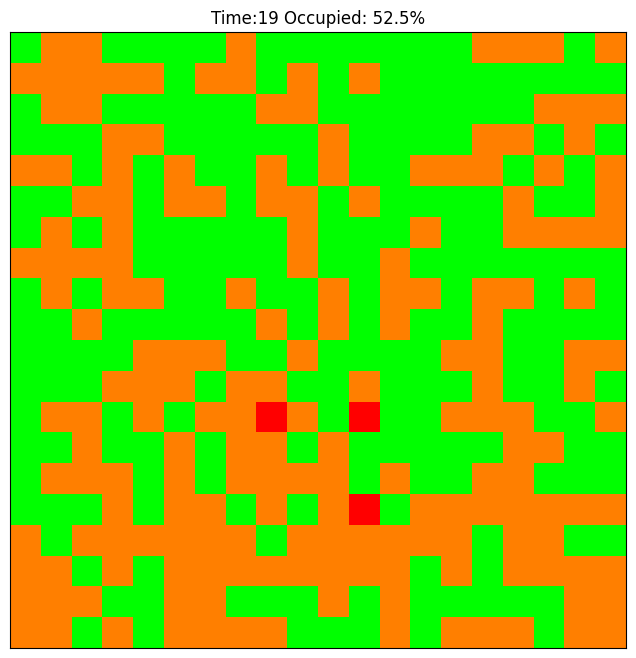

In [79]:
# initialize object and grid with all parameteres nr of rows (n), probability_random_forested (p), probability_random_fire (f) and initial forest density (q)
fire = ForestFire5(20, 0.01, 0.001, 0.5) 

# create Animation2D object & set number of frames/steps per frame
animation = Animation2D(fire, frames=20, steps_per_frame=1)

animation.animate(interval=0.3)



In [80]:
#define fire model 5
fire5 = ForestFire5(100, 0.01, 0.001, 1) 

fire55 = ForestFire5(100, 0.01, 0.001, 0.1) 

fire555 = ForestFire5(100, p=0.01, f=0.01, q=0.5) 

fire5555 = ForestFire5(100, p=0.1, f=0.001, q=0.5) 

Graph 1	Graph 11	Graph 111	Graph 1111
0.22		0.22		0.14		0.16

Graph 2	Graph 22	Graph 222	Graph 2222
0.24		0.23		0.16		0.26

Graph 3	Graph 33	Graph 333	Graph 3333
0.29		0.27		0.18		0.32

Graph 4	Graph 44	Graph 444	Graph 4444
0.39		0.37		0.23		0.47

Graph 5	Graph 55	Graph 555	Graph 5555
0.42		0.42		0.26		0.63


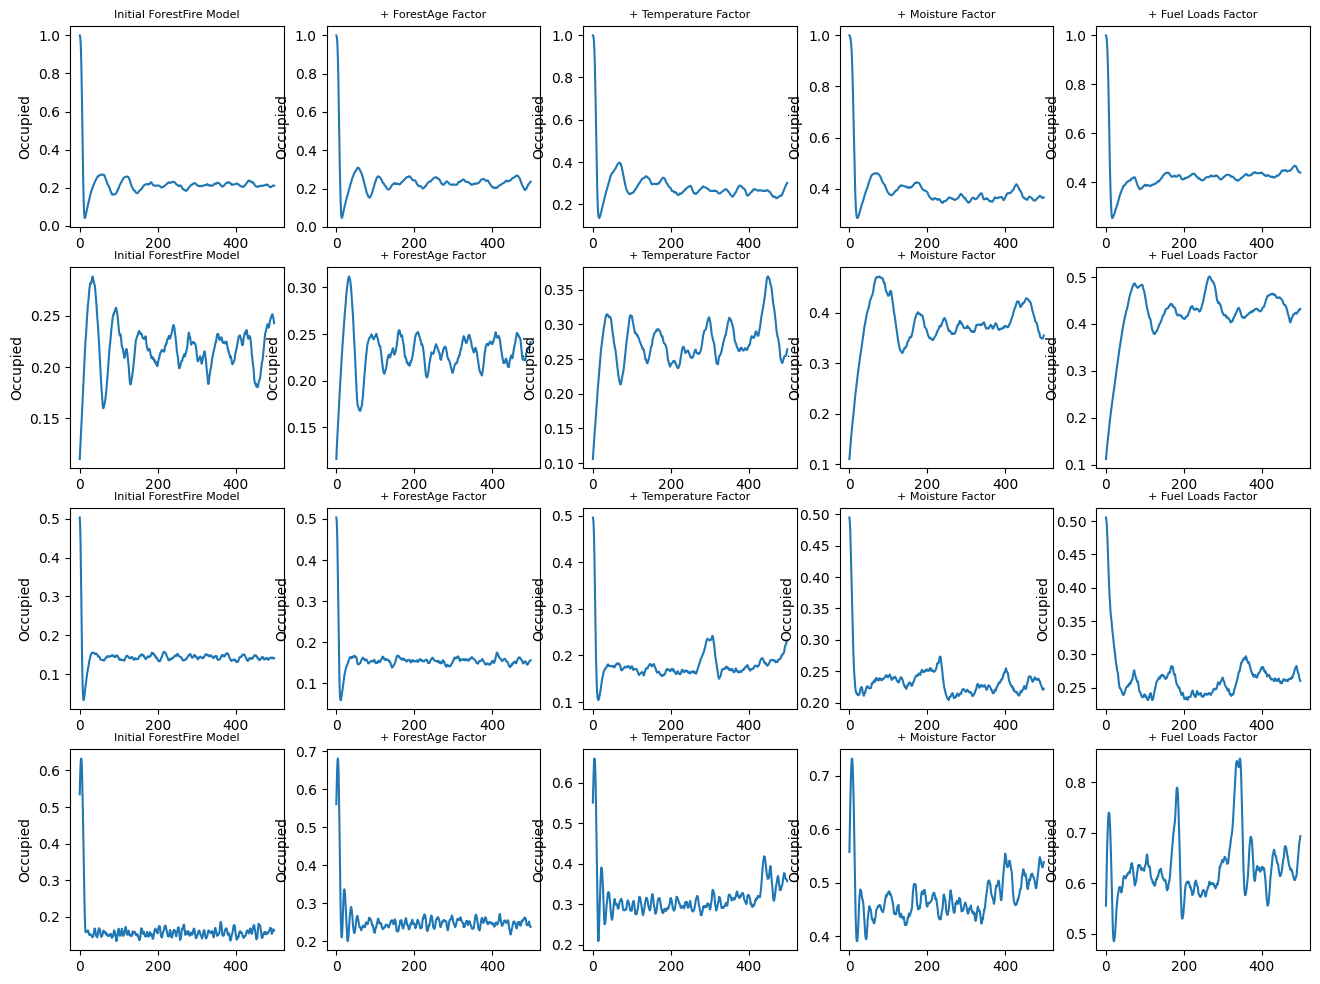

In [81]:

# Credit: Inspired by Joseph Fall

# Create a list of 500 steps for each new "fire" and call ist history...
history1 = []
history2 = []
history3 = []
history4 = []
history5 = []

for i in range(500):
  fire1.step()
  history1.append(fire1.pct_occupied()) 
  fire2.step()
  history2.append(fire2.pct_occupied()) 
  fire3.step()
  history3.append(fire3.pct_occupied())
  fire4.step()
  history4.append(fire4.pct_occupied()) 
  fire5.step()
  history5.append(fire5.pct_occupied()) 


history11 = []
history22 = []
history33 = []
history44 = []
history55 = []

for i in range(500):
  fire11.step()
  fire22.step()
  fire33.step()
  fire44.step()
  fire55.step()
  history11.append(fire11.pct_occupied()) 
  history22.append(fire22.pct_occupied()) 
  history33.append(fire33.pct_occupied()) 
  history44.append(fire44.pct_occupied()) 
  history55.append(fire55.pct_occupied()) 
  
history111 = []
history222 = []
history333 = []
history444 = []
history555 = []

for i in range(500):
  fire111.step()
  fire222.step()
  fire333.step()
  fire444.step()
  fire555.step()
  history111.append(fire111.pct_occupied()) 
  history222.append(fire222.pct_occupied()) 
  history333.append(fire333.pct_occupied()) 
  history444.append(fire444.pct_occupied()) 
  history555.append(fire555.pct_occupied()) 

history1111 = []
history2222 = []
history3333 = []
history4444 = []
history5555 = []

for i in range(500):
  fire1111.step()
  fire2222.step()
  fire3333.step()
  fire4444.step()
  fire5555.step()
  history1111.append(fire1111.pct_occupied()) 
  history2222.append(fire2222.pct_occupied()) 
  history3333.append(fire3333.pct_occupied()) 
  history4444.append(fire4444.pct_occupied()) 
  history5555.append(fire5555.pct_occupied()) 


fig, axes = plt.subplots(4, 5, figsize=(16, 12))


# Unpack the axes into individual variables

plt1, plt2 , plt3, plt4, plt5 = axes[0, 0], axes[0, 1], axes[0, 2], axes[0, 3], axes[0, 4]
plt11, plt22 , plt33, plt44, plt55 = axes[1, 0], axes[1, 1], axes[1, 2], axes[1, 3], axes[1, 4]
plt111, plt222 , plt333, plt444, plt555 = axes[2, 0], axes[2, 1], axes[2, 2], axes[2, 3], axes[2, 4]
plt1111, plt2222, plt3333, plt4444, plt5555 = axes[3, 0], axes[3, 1], axes[3, 2], axes[3, 3], axes[3, 4]


#Plot the lists we created in the previous steps so we can see how the the occupation rate of the fire changes over 500 timesteps
plt1.plot(range(len(history1)), history1)
plt11.plot(range(len(history11)), history11)
plt111.plot(range(len(history111)), history111)
plt1111.plot(range(len(history1111)), history1111)

plt2.plot(range(len(history2)), history2)
plt22.plot(range(len(history22)), history22)
plt222.plot(range(len(history222)), history222)
plt2222.plot(range(len(history2222)), history2222)

plt3.plot(range(len(history3)), history3)
plt33.plot(range(len(history33)), history33)
plt333.plot(range(len(history333)), history333)
plt3333.plot(range(len(history3333)), history3333)

plt4.plot(range(len(history4)), history4)
plt44.plot(range(len(history44)), history44)
plt444.plot(range(len(history444)), history444)
plt4444.plot(range(len(history4444)), history4444)

plt5.plot(range(len(history5)), history5)
plt55.plot(range(len(history55)), history55)
plt555.plot(range(len(history555)), history555)
plt5555.plot(range(len(history5555)), history5555)


# Define the title of the plots
title = "Initial ForestFire Model"
title2 = "+ ForestAge Factor"
title3 = "+ Temperature Factor"
title4 = "+ Moisture Factor"
title5 = "+ Fuel Loads Factor"

# Set up the plot titles and labels
for ax in [plt1, plt11, plt111, plt1111]:
    ax.set_title(title, fontsize=8)
    ax.set_ylabel('Occupied')
for ax in [plt2, plt22, plt222, plt2222]:
    ax.set_title(title2, fontsize=8)
    ax.set_ylabel('Occupied')
for ax in [plt3, plt33, plt333, plt3333]:
    ax.set_title(title3, fontsize=8)
    ax.set_ylabel('Occupied')
for ax in [plt4, plt44, plt444, plt4444]:
    ax.set_title(title4, fontsize=8)
    ax.set_ylabel('Occupied')
for ax in [plt5, plt55, plt555, plt5555]:
    ax.set_title(title5, fontsize=8)
    ax.set_ylabel('Occupied')

#print the averages of the 500 timesteps of each "fire" and display nicely formatted
print("Graph 1\tGraph 11\tGraph 111\tGraph 1111")
print("{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}".format(np.average(history1), np.average(history11), np.average(history111), np.average(history1111)))

print("\nGraph 2\tGraph 22\tGraph 222\tGraph 2222")
print("{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}".format(np.average(history2), np.average(history22), np.average(history222), np.average(history2222)))

print("\nGraph 3\tGraph 33\tGraph 333\tGraph 3333")
print("{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}".format(np.average(history3), np.average(history33), np.average(history333), np.average(history3333)))

print("\nGraph 4\tGraph 44\tGraph 444\tGraph 4444")
print("{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}".format(np.average(history4), np.average(history44), np.average(history444), np.average(history4444)))

print("\nGraph 5\tGraph 55\tGraph 555\tGraph 5555")
print("{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}".format(np.average(history5), np.average(history55), np.average(history555), np.average(history5555)))

**Experimenting with Grazing Model:**

As we can see in the graphs above, each addition of a factor increases the chaos and complexity in the model and graph, which is a logical consequence of adding new rules. 
They are similiar in that all of the models with the different inputs, find an attractor, although there are clearer tendencies for simpler graphs than more complex ones where many different factors have been added.
The more factors you add to a model, the more unpredictable it gets (chaotic and more random in a way), which might be more realistic, but it also becomes less useful. A useful part of a model is it's predictability, which we lose the more realistic the model becomes.
Yet, the different models help us understand what kind of unpredicable behaviour a fire might display in the real world (steady but increasing, or erratic but horizontal etc.), which might be helpful even if we don't know what direction it might move.


**Algorith Analysis**

In [82]:
# Measure execution time of fire1
code1 = 'fire1.step()'
execution_time1 = timeit.timeit(code1, globals=globals(), number=1000)  # Run the code 1000 times

# Print execution time
print("Execution time (ms) Intial Forest Fire Model:", execution_time1 * 1000) 

# Measure execution time of fire2
code2 = 'fire2.step()'
execution_time2 = timeit.timeit(code2, globals=globals(), number=1000)  # Run the code 1000 times

# Print execution time
print("Execution time (ms) Forest Age Factor:", execution_time2 * 1000) 

# Measure execution time of fire3
code3 = 'fire3.step()'
execution_time3 = timeit.timeit(code3, globals=globals(), number=1000)  # Run the code 1000 times

# Print execution time
print("Execution time (ms) Temperature Factor:", execution_time3 * 1000) 

# Measure execution time of fire4
code4 = 'fire4.step()'
execution_time4 = timeit.timeit(code4, globals=globals(), number=1000)  # Run the code 1000 times

# Print execution time
print("Execution time (ms) Moisture Factor:", execution_time4 * 1000) 

# Measure execution time of fire5
code5 = 'fire5.step()'
execution_time5 = timeit.timeit(code5, globals=globals(), number=1000)  # Run the code 1000 times

# Print xecution time
print("Execution time (ms) Fuel Loads Factor:", execution_time5 * 1000) 


# Calculate percentage increase between different factors
percentage_increase_1_to_2 = ((execution_time2 - execution_time1) / execution_time1) * 100
percentage_increase_2_to_3 = ((execution_time3 - execution_time2) / execution_time2) * 100
percentage_increase_3_to_4 = ((execution_time4 - execution_time3) / execution_time3) * 100
percentage_increase_4_to_5 = ((execution_time5 - execution_time4) / execution_time4) * 100

# Print the percentage increase between different factors
print("Percentage increase from Intial Forest Fire Model to Forest Age Factor:", percentage_increase_1_to_2, "%")
print("Percentage increase from Forest Age Factor to Temperature Factor:", percentage_increase_2_to_3, "%")
print("Percentage increase from Temperature Factor to Moisture Factor:", percentage_increase_3_to_4, "%")
print("Percentage increase from Moisture Factor to Fuel Loads Factor:", percentage_increase_4_to_5, "%")

Execution time (ms) Intial Forest Fire Model: 1156.1682599999585
Execution time (ms) Forest Age Factor: 1493.4542569999394
Execution time (ms) Temperature Factor: 1828.1679530000474
Execution time (ms) Moisture Factor: 8631.808044000081
Execution time (ms) Fuel Loads Factor: 8417.483182000069
Percentage increase from Intial Forest Fire Model to Forest Age Factor: 29.17274316110295 %
Percentage increase from Forest Age Factor to Temperature Factor: 22.412048740781863 %
Percentage increase from Temperature Factor to Moisture Factor: 372.1561840002267 %
Percentage increase from Moisture Factor to Fuel Loads Factor: -2.4829660357077583 %


**Algorith Analysis**

- Intial Forest Fire Model:

The big-O time complexity is O(N^2) for the correlate2D function. This means that this algorithms computation time grows significantly the bigger the input is (quadratic). It will also use more memory and scalability is significantly reduced.The execution time for only the Inital Forest Model is typically between 1000 - 2000 ms.

+ Forest Age Factor:

The big-O time complexity is + (O(N) * X) for the addition of the Forest Age Factor. Here the consequences are the same as in the initial model: This means that this algorithms computation time grows significantly for the bigger the input is (quadratic). It will also use more memory and scalability is significantly reduced. The execution time for the Forest Age factor is typically very similar to the Initial Forest Fire Model, which is expected as the time complexity of (O(N) * X) that is added, doesn't usually contribute significantly to the execution time.


+ Temperature Factor:

The big-O time complexity is + (O(N) * X) for the addition of the Temperature Factor. Here the additional time needed for computation only increases linearly, which isn't usually too bad. Here it's similar to the Forest Age Factor, where the execution time for Temperature Factor is very similar to the Initial Forest Fire Model 6 Forest Age Factor, which is expected as the time complexity of (O(N) *) that is added, doesn't usually contribute significantly to the execution time.


+ Moisture Factor:

The big-O time complexity is + (O(N) * X) for the addition of the Moisture Factor. Same as with Temperature Factor: Here the time needed for computation only increases linearly, which usually isn't bad at all and usually much better than the Forest Age factor. The actual execution time of the Moisture Factor is significantly longer than any other Factor before and the difference between the previous Factor is also the highest. This to me is very surprising on first sight as time complexity should also only be (O(N) * X). My attempt to explain the big difference is that because the input array might not be extremely big, the several multiplication of O(N) in this specific example can take longer than O(N^2), depending on how often O(N) appears in the code.

+ Fuel Loads Factor:

The big-O time complexity is once again + (O(N) * X) for the addition of the Fuel Loads Factor. Same as with Temperature Factor & Moisture Factor: Here the time needed for computation only increases linearly, which usually isn't bad at all and normally much better than the Forest Age factor. The actual increase in execution time here is similar to the first two added factors.



Overall, the expected execution times were consistent with its time complexity, except the Moisture factor, which took a lot longer to execute than anticipated.
